## 벽돌깨기 - DQN
---
Deep-Q-Network 방식으로 인공지능이 플레이하는 벽돌깨기를 구현.

"Human level control through deep reinforcement learning" - V Mnih, et al. 2015 

[논문 링크](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)

In [1]:
# 필요 패키지를 호출
import sys
sys.path.append('../')
import numpy as np
import torch

# material - atari_util에 필요한 모듈을 호출
from material.atari_util import *

import gym
import matplotlib.pyplot as plt
from PIL import Image 

/home/hshwang/anaconda3/envs/RL_scratch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/hshwang/anaconda3/envs/RL_scratch/lib/python3.8/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


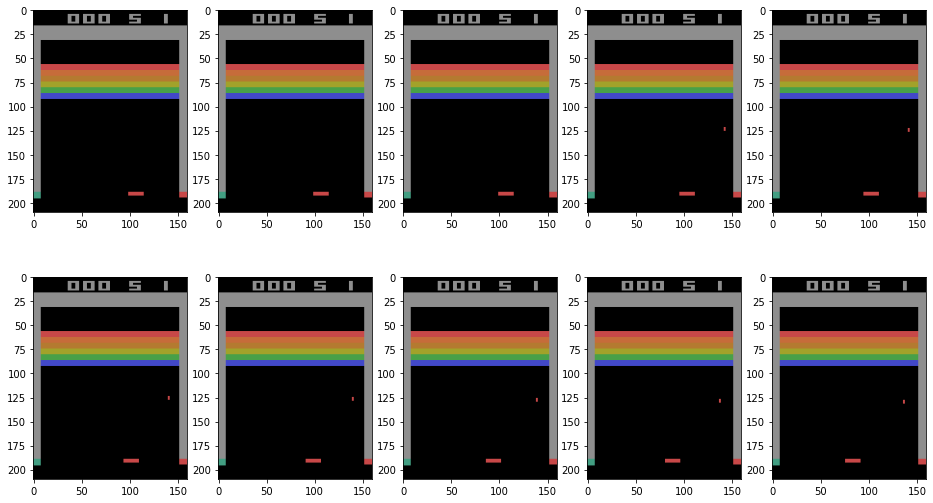

In [2]:
# 환경 분석 - 게임 화면부터 살펴봅시다
env = gym.make("BreakoutNoFrameskip-v4")
env.reset()

fig = plt.figure(figsize=(16,9))

# 임의의 10번의 행동을 수행하면서 환경을 렌더링
for row in range(5):
    for col in range(2):
        ax = fig.add_subplot(2,5,row*2+col+1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

In [3]:
# 이미지 크기
img = np.array(env.render('rgb_array'))#.shape
print(img.shape)

(210, 160, 3)


### Step 1. 게임 화면 전처리
---
개요

1. 실제 아타리 게임화면 이미지(채널,가로,세로) $\rightarrow$ (3,210,160)

2. 실제 이미지는 불필요한 정보를 담고 있음 $\rightarrow$ 이미지 Crop & resizing

---

방법 

1. 불필요한 이미지 Crop (점수판)

2. 이미지 사이즈 조절 (3,21,160) $\rightarrow$ (1,64,64): 컬러에서 회색조, 가로 세로 64x64

In [13]:
from gym.core import ObservationWrapper
from gym.spaces import Box

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size,dtype=np.float32)

    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        dummy = 0
        for idx,channel_weight in enumerate(channel_weights):
            dummy += channel_weight*(rgb[:,:,idx])
        return np.expand_dims(dummy,axis=-1)
    
    def observation(self, img):      
        img = Image.fromarray(np.uint8(img),'RGB')
        img = img.resize((64,64))
        img = np.array(img)
        img = self._to_gray_scale(img)/255.
        return np.array(img,dtype=np.float32).transpose((2,0,1))

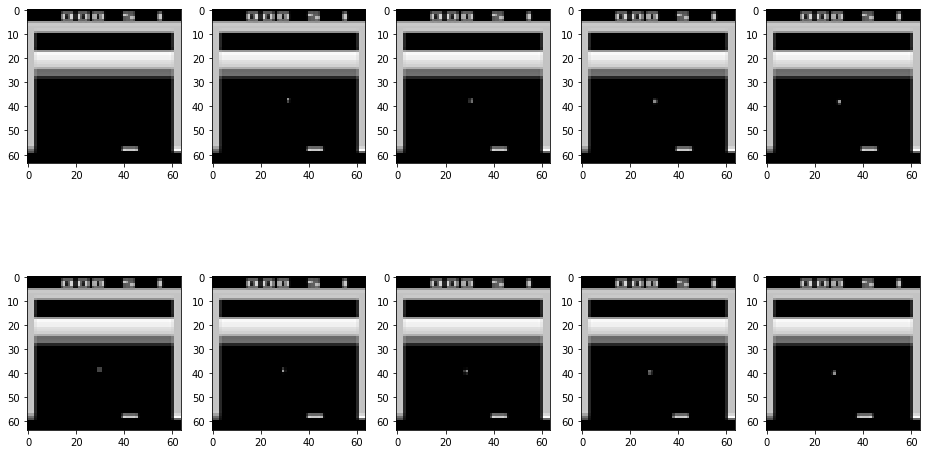

In [15]:
env = gym.make("BreakoutNoFrameskip-v4") 
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()